# Graph Network-based Simulator (GNS)

Gonzalez et al. first introduced the concept and architecture of the GNS in 2020 in their now classic [paper](https://proceedings.mlr.press/v119/sanchez-gonzalez20a.html). Since then, several fields have implemented the architecture for particle simulations due to certain favorable inductive biases of the architecture and implementation. We explore the question if the GNS architecture is also useful for FEM based simulations in the *inverse* problem with *output-only* data. Determining the parameters of a physical system with output-only measurements of a proxy of the true state is still an open problem. To begin this feasibility study, we start with a toy example, starting with a static loading problem and a simple Euler-Bernoulli cantilever beam. We also build the necessary code to solve more complicated problems in the future

## Installing packages

In [1]:
import os
import torch
import math
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

PyTorch has version 2.3.1+cu121 with cuda 12.1


In [2]:
!pip install torch_geometric

# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 47.6 MB/s eta 0:00:00


In [3]:

from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, radius_graph
from torch_geometric.utils import add_self_loops
import torch_cluster
import torch_scatter
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")


from torch.utils.tensorboard import SummaryWriter
os.makedirs('train_log', exist_ok=True)
os.makedirs('rollouts', exist_ok=True)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn

PyTorch has version 2.3.1+cu121 with cuda 12.1


In [4]:
# import tree
# from tqdm import tqdm

## Building the GNS

The rough workflow is as follows:

$$ x \rightarrow G \rightarrow Encoder \rightarrow Processor \rightarrow Decoder \rightarrow y$$

First, create a function to generate a graph from raw data.

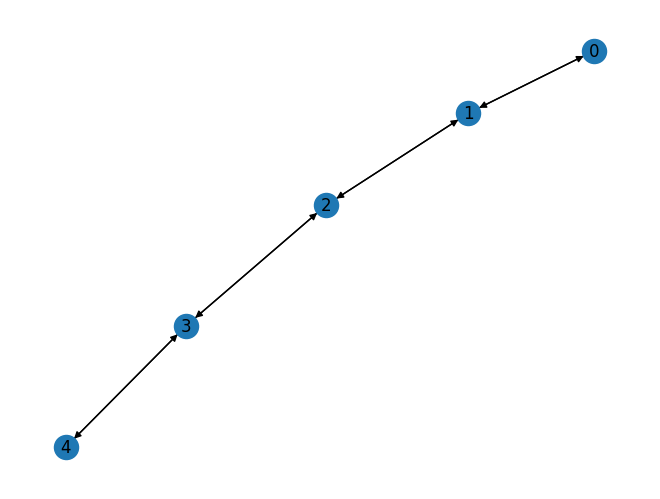

tensor([[ 1.0000, -1.0000,  0.0000,  8.3102],
        [ 1.0000,  1.0000,  0.0000,  4.2474],
        [ 1.0000, -1.0000,  0.0000,  5.2880],
        [ 1.0000,  1.0000,  0.0000,  6.8080],
        [ 1.0000, -1.0000,  0.0000,  6.6117],
        [ 1.0000,  1.0000,  0.0000,  8.3579],
        [ 1.0000, -1.0000,  0.0000,  7.0781],
        [ 1.0000,  1.0000,  0.0000,  9.2992]])


In [5]:
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph
from torch_geometric.utils import to_networkx
import networkx as nx

def create_gnn_graph(coordinates, metadata):
    """
    Create a graph data object for a GNN model.

    Args:
    - coordinates (list of tuples): A list of 2D coordinates for each node.
    - E_initial (float): The initial value for the edge attribute.

    Returns:
    - data (Data): A PyG Data object representing the graph.
    """

    # Convert coordinates to tensor
    node_features = torch.tensor(coordinates, dtype=torch.float)

    # Add the load as a node attribute
    load = torch.rand(node_features.size(0), 1) * metadata["P_initial"]
    dist_boundary = torch.norm(node_features - torch.tensor([[0, 0]], dtype=torch.float), dim=1).unsqueeze(1)

    # Create edges
    num_nodes = len(coordinates)
    edge_index = radius_graph(node_features, r=metadata["default_connectivity_radius"], loop=False)

    # Calculate edge attributes (e.g., Euclidean distance)
    distance = torch.norm(node_features[edge_index[0]] - node_features[edge_index[1]], dim=1).unsqueeze(1)
    # Calculate displacement as vector at each edge
    displacement = (node_features[edge_index[1]] - node_features[edge_index[0]])

    # Convert E_initial to a PyTorch tensor
    E_initial = torch.tensor(metadata["E_initial"], dtype=torch.float)
    # Correctly generate a tensor with random values uniformly distributed between 0 and 1, then scale by E_initial
    E_edge = torch.rand(edge_index.size(1), 1) * E_initial

    # Now, both tensors have shape [number_of_edges, 1] and can be concatenated
    edge_attr = torch.cat([distance, displacement, E_edge], dim=1)

    # Create a graph data object
    graph_data = Data(pos=node_features, edge_index=edge_index, edge_attr=edge_attr, node_attr=load)

    return graph_data

# Example usage
metadata = {"default_connectivity_radius": 1.6, "E_initial": 10, "P_initial": 0}
coordinates = [(0.5, 0), (1.5, 0), (2.5, 0), (3.5, 0), (4.5, 0)]
graph_data = create_gnn_graph(coordinates, metadata)

graph = to_networkx(graph_data)
nx.draw(graph, with_labels=True)
plt.show()

print(graph_data.edge_attr)

We can then code up a simple MLP helper class to use in our architecture.

In [6]:
# class MLP(nn.Module):
#     """
#     Create a simple MLP
#     """
#     def __init__(
#         self,
#         input_size,
#         layer_sizes,
#         output_size=None,
#         output_activation=torch.nn.Identity,
#         activation=torch.nn.ReLU,
#         layernorm=True
#     ):
#         super(MLP, self).__init__()
#         sizes = [input_size] + layer_sizes
#         if output_size is not None:
#             sizes.append(output_size)
#         layers = []
#         for i in range(len(sizes) - 1):
#             layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
#             if layernorm and i < len(sizes) - 2:
#                 layers.append(torch.nn.LayerNorm(sizes[i + 1]))
#             if i < len(sizes) - 2:
#                 layers.append(activation())
#             else:
#                 layers.append(output_activation())
#         self.model = torch.nn.Sequential(*layers)

#     def forward(self, x):
#         return self.model(x)

In [7]:
class MLP(nn.Module):
    """
    Create a simple MLP
    """
    def __init__(
        self,
        input_size,
        layer_sizes,
        output_size=None,
        output_activation=torch.nn.Identity,
        activation=torch.nn.ReLU
    ):
        super(MLP, self).__init__()
        sizes = [input_size] + layer_sizes
        if output_size is not None:
            sizes.append(output_size)
        layers = []
        for i in range(len(sizes) - 1):
            if (i < len(sizes) - 2):
                act = activation
            else:
                act = output_activation
            layers += [torch.nn.Linear(sizes[i], sizes[i + 1]), act()]
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

### Encoder and Decoder

We then can create our encoder and decoder classes.

In [8]:
class Encoder(nn.Module):
    def __init__(
        self,
        node_in, # same shape as the data vertices (nodes) WARNING
        node_out, # shape for the processor block
        edge_in, # same shape as the data edges (elements)
        edge_out, # shape for the processor block
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(Encoder, self).__init__()

        ############################################################################
        # TODO: Implement the encoder.
        # Hint: The node_fn and edge_fn are of the same structure, which is a MLP layer followed by a layer norm
        ############################################################################
        self.node_fn = nn.Sequential(*[MLP(node_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out),
            nn.LayerNorm(node_out)])
        self.edge_fn = nn.Sequential(*[MLP(edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], edge_out),
            nn.LayerNorm(edge_out)])
        ############################################################################

    def forward(self, x, e_features): # global_features
        '''
        x: (E, node_in)
        edge_index: (2, E)
        e_features: (E, edge_in)
        '''
        return self.node_fn(x), self.edge_fn(e_features)

class Decoder(nn.Module):
    def __init__(
        self,
        node_in, # directly from the processor
        node_out, # this shape needs to be (num_nodes of real problem x 2). The first column should be u, the second should be p.
        edge_in, # directly from the processor
        edge_out, # this shape needs to be (num_elements of real problem x 1). The first column should be ei.
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(Decoder, self).__init__()
        ############################################################################
        # Implement the decoder.
        # The decoder outputs both node and edge information.
        ############################################################################
        self.node_fn = MLP(node_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out)
        self.edge_fn = MLP(edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], edge_out)
        ############################################################################

    def forward(self, x, e_features):
        '''
        x: (E, node_in)
        e_features: (E, edge_in)
        '''
        ############################################################################
        # Implement the forward pass.
        ############################################################################
        return self.node_fn(x), self.edge_fn(e_features)
        ############################################################################



### Message passing

We now can create the message passing to be used in the Processor.

In [9]:
class InteractionNetwork(MessagePassing):
    def __init__(
        self,
        node_fn,
        edge_fn,
    ):
        super().__init__()
        self.node_fn = node_fn
        self.edge_fn = edge_fn

    def forward(self, x, edge_index, e_features):
        x_updated, e_updated = self.propagate(edge_index=edge_index, x=x, e_features=e_features)
        return x_updated, e_updated

    def message(self, edge_index, x_i, x_j, e_features):
        message = torch.cat([x_i, x_j, e_features], dim=-1)
        message = self.edge_fn(message)
        return message

    def aggregate(self, messages, index, dim_size=None):
        out = torch_scatter.scatter(messages, index, dim=self.node_dim, dim_size=dim_size, reduce="sum")
        return (messages, out)

    def update(self, aggr_out, x, e_features):
        message, aggr = aggr_out
        x_updated = torch.cat([aggr, x], dim=-1)
        x_updated = self.node_fn(x_updated)
        return x_updated+x, e_features+message

### Processor

The processer has $M$ layers of InteractionNetworks

In [10]:
class Processor(MessagePassing):
    def __init__(
        self,
        node_in,
        node_out,
        edge_in,
        edge_out,
        num_message_passing_steps,
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(Processor, self).__init__(aggr='max')
        self.gnn_stacks = nn.ModuleList([
            InteractionNetwork(
                node_fn = nn.Sequential(*[MLP(node_in+edge_out, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out),
                nn.LayerNorm(node_out)]),
                edge_fn = nn.Sequential(*[MLP(node_in+node_in+edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], edge_out),
                nn.LayerNorm(edge_out)])
            ) for _ in range(num_message_passing_steps)])

    def forward(self, x, edge_index, e_features):
        for gnn in self.gnn_stacks:
            x, e_features = gnn(x, edge_index, e_features)
        return x, e_features

Combining the encoder, processor, and decoder into a single network.

In [11]:
class EncodeProcessDecode(nn.Module):
    def __init__(
        self,
        node_in,
        node_out,
        edge_in,
        edge_out,
        latent_dim,
        num_message_passing_steps,
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(EncodeProcessDecode, self).__init__()
        ############################################################################
        # Implementation of the encoder, processor, and decoder
        ############################################################################
        self._encoder = Encoder(
            node_in=node_in,
            node_out=latent_dim,
            edge_in=edge_in,
            edge_out=latent_dim,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )

        self._processor = Processor(
            node_in=latent_dim,
            node_out=latent_dim,
            edge_in=latent_dim,
            edge_out=latent_dim,
            num_message_passing_steps=num_message_passing_steps,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )

        self._decoder = Decoder(
            node_in=latent_dim,
            node_out=node_out,
            edge_in=latent_dim,
            edge_out=edge_out,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )
        ############################################################################

    def forward(self, x, edge_index, e_features):
        ''' forward pass of the architecture
          x: (E, node_in) -> e.g., (5, 3) if there are 5 nodes each with 3 features
          edge_index: (2, num_edges) -> e.g., (2, 4) if there are 4 edges
          e_features: (E, edge_in) -> e.g., (5, 4) if there are 5 edges each with 4 features
        '''
        ############################################################################
        # TODO: implementation of making a forward pass through the encoder,
        # processor, and decoder blocks
        ############################################################################
        x, e_features = self._encoder(x, e_features)
        x, e_features = self._processor(x, edge_index, e_features)
        node_decoded, edge_decoded = self._decoder(x, e_features)
        return node_decoded, edge_decoded
        ############################################################################


The simulator puts it all together, from raw data to prediction. For the static case, the input is just a single 1-D array of values position values.

In [26]:
class Simulator(nn.Module):
    def __init__(
        self,
        num_nodes,
        num_edges,
        node_dimension,
        edge_dimension,
        node_in,
        edge_in,
        latent_dim, # this is what we choose for the size of the network
        num_message_passing_steps, # this is M
        mlp_num_layers,
        mlp_hidden_dim,
        connectivity_radius,
        # device='cpu',
    ):
        super(Simulator, self).__init__()
        self._connectivity_radius = connectivity_radius

        self._encode_process_decode = EncodeProcessDecode(
            node_in=node_in,
            node_out=node_dimension,
            edge_in=edge_in,
            edge_out=edge_dimension,
            latent_dim=latent_dim,
            num_message_passing_steps=num_message_passing_steps,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )

        # self._device = device

    # def _create_gnn_graph(self, coordinates):
    #     """
    #     Create a graph data object for a GNN model.

    #     Args:
    #     - coordinates (list of tuples): A list of 2D coordinates for each node.

    #     Returns:
    #     - data (Data): A PyG Data object representing the graph, with edge and node features purley from the coordinates
    #     """

    #     # Convert coordinates to tensor
    #     pos = torch.tensor(coordinates, dtype=torch.float)

    #     # Concat node features and load
    #     node_features = torch.cat([pos], dim=1)
    #     # Create edges
    #     num_nodes = len(coordinates)
    #     edge_index = radius_graph(pos, r=self._connectivity_radius, loop=False)
    #     # Calculate edge attributes (e.g., Euclidean distance)
    #     distance = torch.norm(pos[edge_index[0]] - pos[edge_index[1]], dim=1).unsqueeze(1)
    #     # Calculate displacement as vector at each edge
    #     displacement = (pos[edge_index[1]] - pos[edge_index[0]])

    #     edge_attr = torch.cat([distance, displacement], dim=1)
    #     return node_features,edge_index, edge_attr

    def _create_gnn_graph(self, coordinates):
      pos = coordinates  # Use coordinates directly
      node_features = pos
      edge_index = radius_graph(pos, r=self._connectivity_radius, loop=False)
      distance = torch.norm(pos[edge_index[0]] - pos[edge_index[1]], dim=1).unsqueeze(1)
      displacement = pos[edge_index[1]] - pos[edge_index[0]]
      edge_attr = torch.cat([distance, displacement], dim=1)
      return node_features, edge_index, edge_attr

    def _decoder_post_processor(self, node_decoded, edge_decoded):
      ''' TODO: We want to use the decoded edges and features to feed into the next iteration of gradient step
      '''
      #         edge_decoded = edge_attr = torch.cat([distance, displacement, E_edge], dim=1)
      #         node_decoded = node_features = torch.cat([pos, load], dim=1)
      # extract the nodal information

      # deflection at each node, (num_nodes x 1), one deflection value in meters for each node
      u = node_decoded

      # force applied at each node, (num_nodes x 1), one force magnitude value in meters for each node
      # p = node_decoded

      # flexural rigidity for each edge, (num_edges x 1), one value for flexural rigidity
      # ei = edge_decoded

      return u#,p,ei

    def forward(self, coordinates):
      ''' TODO: Change this to predict the new features of u, EI, and p

      '''
      node_features, edge_index, e_features = self._create_gnn_graph(coordinates)
      node_decoded, edge_decoded = self._encode_process_decode(node_features, edge_index, e_features)
      u = self._decoder_post_processor(node_decoded, edge_decoded)

      # u,p,ei = self._decoder_post_processor(node_decoded, edge_decoded)
      return u#,p,ei  # to be used in loss calculation



### Training function implementation

We have the non-trivial task of computing the pde loss, $\mathbf{L}_{pde}$. We'll be formulating the loss by minimizing the residual of the Euler-Bernoulli beam differential equation. This is the main way of how we enforce our (soft) physics constraint.

In [45]:
# def net_f(x, u):
#     x.requires_grad = True
#     u_x = torch.autograd.grad(u, x, create_graph=True, grad_outputs=torch.ones_like(u), allow_unused=True)[0]
#     u_xx = torch.autograd.grad(u_x, x, create_graph=True, grad_outputs=torch.ones_like(u), allow_unused=True)[0]

#     f = 1*(x(-1)) - u_xx * E
#     return f
def residual_r(x, u):
  ''' pde residual computation function
    Args:
      x is the position of the beam
      u is the displacement of the beam (output of the GNS)
  '''
  u_x = torch.autograd.grad(outputs=u, inputs=x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
  if u_x is None:
      raise RuntimeError("Gradient computation failed for u_x")
  u_xx = torch.autograd.grad(outputs=u_x, inputs=x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
  if u_xx is None:
      raise RuntimeError("Gradient computation failed for u_xx")
  e = 2e11  # Young's modulus
  r = 1 * x[-1] - u_xx * e
  return torch.mean(torch.square(r))


# def train_step( X_u_train_t, u_train_t, X_f_train_t, opt, nu):
#     x_u = X_u_train_t[:,0:1]

#     x_f = X_f_train_t[:,0:1]

#     opt.zero_grad()
#     u_nn = net_u(torch.cat([x_u, t_u],1))
#     f_nn = net_f(x_f,t_f, nu)
#     loss =  torch.mean(torch.square(u_nn - u_train_t)) + torch.mean(torch.square(f_nn))
#     loss.backward()
#     opt.step()
#     return loss

We can now write our main training function to loop through a specified number of epochs.

In [50]:
def train(lr, lambda_pde, epochs, simulator, x_data, y_data, printouts=10):
  ''' TODO: Implement the training loop.
    Args:
      simulator: the simulator model
      x_data: our features (only positions)
      y_data: our labels (only displacement)
  '''
  loss_fn = torch.nn.MSELoss() # pure data loss
  optimizer = torch.optim.Adam(simulator.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / 5e3))

  # recording loss curve
  train_loss_list = []
  pred_history_list = []


  for epoch in range(epochs):
      simulator.train()
      total_loss = 0
      batch_count = 0
      # data = x_data.clone().detach().requires_grad_(True)
      data = x_data.requires_grad_(True)
      optimizer.zero_grad()
      pred = simulator.forward(data)
      loss_pde = residual_r(data, pred)
      # print('pred shape',pred.shape)
      # print('y_data shape',y_data.shape)
      loss_data = loss_fn(pred, y_data)

      loss = lambda_pde * loss_pde + loss_data
      loss.backward()
      optimizer.step()
      scheduler.step()

      # Calculate the interval for printing the loss
      print_interval = max(1, epochs // printouts)
      if epoch % print_interval == 0 or epoch == epochs - 1:
        print({"epoch": epoch, "data loss": loss_data.item(), "lr": optimizer.param_groups[0]["lr"]})

      # append losses and predictions
      train_loss_list.append((epoch, loss_data.item()))
      pred_history_list.append(pred)

  return train_loss_list, pred_history_list # return loss and prediction history

"Training" only one set of data at a time. What we're $\textbf{really}$ doing is optimization with soft constraints using a nonlinear model (the GNS) as the mapping from $x \rightarrow y$ i.e.  $\phi_{\theta}(x) = y$.


Let's start with this data file: "node-disp_l=10_n=100_p=10000.csv"

In [51]:
# load dataset
data_df = pd.read_csv("node-disp_l=100_n=100_p=100000.csv")

data_df.head()
data_x = torch.tensor(data_df['position'].values).view(100, 1).float()

print(data_x.shape)
data_y_np = data_df['displacement'].values
data_y = torch.tensor(data_df['displacement']).view(100, 1).float()
print(data_y.shape)


torch.Size([100, 1])
torch.Size([100, 1])


In [52]:
# build model
simulator = Simulator(
    num_nodes=100,
    num_edges=99,
    node_dimension=1,
    edge_dimension=2,
    node_in=1,
    edge_in=2,
    latent_dim=3,
    num_message_passing_steps=2,
    mlp_num_layers=3,
    mlp_hidden_dim=5,
    connectivity_radius=1.011,
)


In [53]:
# train the model
train_loss_list, pred_history_list = train(lr = 1e-2,
      epochs = 100,
      lambda_pde =2,
      simulator = simulator,
      x_data = data_x,
      y_data = data_y,
      printouts=10
      );

{'epoch': 0, 'data loss': 5455.611328125, 'lr': 0.009995395890030878}
{'epoch': 10, 'data loss': 5433.27294921875, 'lr': 0.009949471217509921}
{'epoch': 20, 'data loss': 5413.333984375, 'lr': 0.009903757549692468}
{'epoch': 30, 'data loss': 5394.4375, 'lr': 0.009858253917099965}
{'epoch': 40, 'data loss': 5378.62255859375, 'lr': 0.009812959354708217}
{'epoch': 50, 'data loss': 5367.50927734375, 'lr': 0.009767872901926903}
{'epoch': 60, 'data loss': 5356.56494140625, 'lr': 0.009722993602579218}
{'epoch': 70, 'data loss': 5345.69677734375, 'lr': 0.00967832050488159}
{'epoch': 80, 'data loss': 5334.904296875, 'lr': 0.009633852661423498}
{'epoch': 90, 'data loss': 5324.18896484375, 'lr': 0.009589589129147372}
{'epoch': 99, 'data loss': 5314.60791015625, 'lr': 0.009549925860214343}


We now have the history of our training/optimization stored in the two lists: train_loss_list, pred_history_list

### Some visualization functions

In [18]:
def plot_loss_curves(loss_tuple):
  ''' function to plot the loss curve
    Args:
      loss_tuple: the tuple that comes directly out of the training function
  '''
  # extract the default tuple
  epochs = [item[0] for item in loss_tuple]
  loss = [item[1] for item in loss_tuple]
  # Creating the plot
  fig, ax = plt.subplots(figsize=(10,5))

  # Plotting the loss curve
  ax.plot(epochs, loss, linestyle='-',label='Data loss')

  # Adding title and labels
  ax.set_title('Loss Curve')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')

  # Adding a legend
  ax.legend()

  # Displaying the plot
  plt.show()

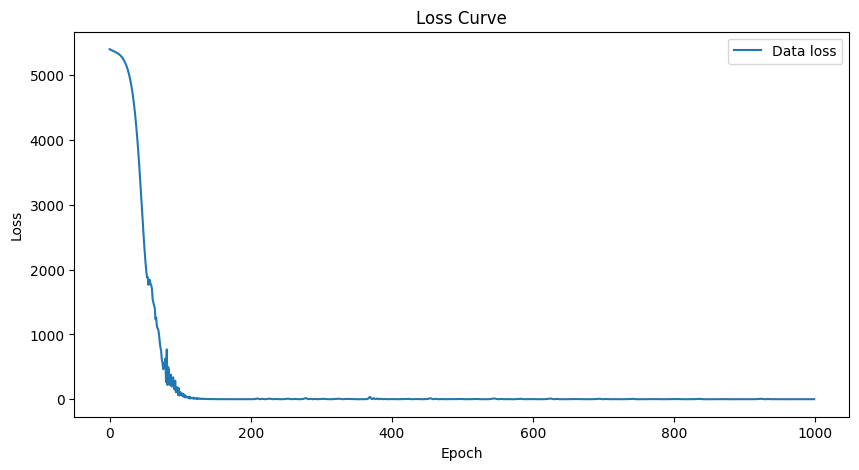

In [19]:
plot_loss_curves(loss_tuple=train_loss_list)

In [20]:
def plot_prediction(prediction, data_y_np, title='Prediction comparison',length=1, num_nodes=100):
  ''' function to plot the prediction curve
  '''
  # Creating the plot
  fig, ax = plt.subplots(figsize=(10,5))

  beam_length = np.linspace(0, length, num_nodes)

  # Plotting the prediction curve
  ax.plot(beam_length, prediction, linestyle='-', label='Prediction')
  # Plotting true curve
  ax.plot(beam_length, data_y_np, linestyle='-', label='True')


  # Adding title and labels
  ax.set_title('Prediction comparison')
  ax.set_xlabel('Length')
  ax.set_ylabel('Deflection')

  # Adding a legend
  ax.legend()

  # Displaying the plot
  plt.show()

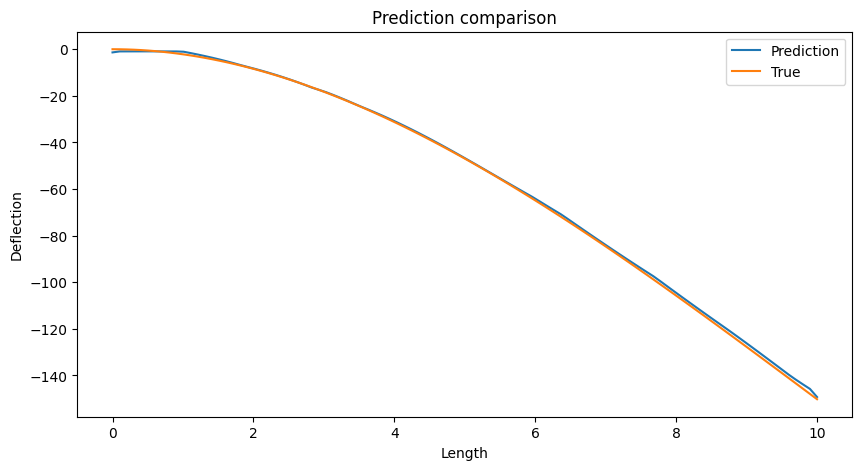

In [21]:
plot_prediction(prediction=pred_history_list[-1].cpu().detach().numpy(),
                data_y_np=data_y_np,
                title='Prediction comparison (only data loss)',
                length=10)

Animation code.

In [ ]:
import matplotlib.animation as animation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Function to plot prediction for a given epoch
def plot_prediction_ani(beam_length, prediction, true_curve, epoch, ax,length,y_min, y_max):
    ax.clear()
    ax.plot(beam_length, prediction, linestyle='-', label='Prediction')
    ax.plot(beam_length, true_curve, linestyle='-', label='True')
    ax.set_title(f'Prediction comparison - Epoch {epoch + 1}')
    ax.set_xlabel('Length')
    ax.set_ylabel('Deflection')
    ax.set_xlim(0, length*1.1)
    ax.set_ylim(y_min,y_max)
    ax.legend()

# Function to create animation
def create_animation(predictions, true_curve, length=1, num_nodes=100, interval=100):
    fig, ax = plt.subplots(figsize=(10, 5))
    beam_length = np.linspace(0, length, num_nodes)
    y_min = np.min(true_curve)*1.1
    y_max = np.max(true_curve)*1.1
    def update(epoch):
      # print(predictions[epoch])
      plot_prediction_ani(beam_length, predictions[epoch], true_curve, epoch, ax,length,y_min,y_max)

    ani = animation.FuncAnimation(fig, update, frames=len(predictions), interval=interval, repeat=True)

    # Save animation as gif (uncomment to save)
    ani.save('predictions.gif', writer='imagemagick')

    plt.show()
    return ani



In [ ]:
# Example data preparation
num_epochs = len(pred_history_list)  # Number of epochs based on your data
num_nodes = 100  # Adjust as needed
length = 100  # Your specific length

# Extract predictions from your history list
predictions = [pred.cpu().detach().numpy() for pred in pred_history_list]

# Example true curve (adjust based on your specific data)
true_curve = data_y_np

# Create animation
create_animation(predictions, true_curve, length, num_nodes)

### Some space to debug snippets of code

In [ ]:

#PDE Differentiation by MA

def net_f(x, u):
    x.requires_grad = True
    u_x = torch.autograd.grad(u, x, create_graph=True, grad_outputs=torch.ones_like(u), allow_unused=True)[0]
    u_xx = torch.autograd.grad(u_x, x, create_graph=True, grad_outputs=torch.ones_like(u), allow_unused=True)[0]

    f = 1*(x(-1)) - u_xx * E
    return f



def train_step( X_u_train_t, u_train_t, X_f_train_t, opt, nu):
    x_u = X_u_train_t[:,0:1]

    x_f = X_f_train_t[:,0:1]

    opt.zero_grad()
    u_nn = net_u(torch.cat([x_u, t_u],1))
    f_nn = net_f(x_f,t_f, nu)
    loss =  torch.mean(torch.square(u_nn - u_train_t)) + torch.mean(torch.square(f_nn))
    loss.backward()
    opt.step()
    return loss

In [ ]:
print(type(data_x), data_x.shape)
print(type(data_y), data_y.shape)
print(type(pred_history_list[-1]), pred_history_list[-1].shape)

<class 'torch.Tensor'> torch.Size([100, 1])
<class 'torch.Tensor'> torch.Size([100, 1])
<class 'torch.Tensor'> torch.Size([100])


In [ ]:
test_residual = net_f(data_x,pred_history_list[-1])

TypeError: 'NoneType' object is not iterable